In [24]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import csv

In [14]:
def plot_predictions(test,predicted):
    plt.plot(test,color='red',label='Real Data')
    plt.plot(predicted, color='blue',label='Predicted Data')
    plt.title('Wind Energy Prediction')
    plt.xlabel('Time')
    plt.ylabel('Wind Direction')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [3]:
dataset = pd.read_csv('T.csv', index_col='Date/Time', parse_dates=['Date/Time'])
dataset.head()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
Date/Time,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


In [4]:
# Checking for missing values
training_set = dataset['2018-01':'2018-09'].iloc[:,1:2].values

test_set= dataset['2018-10':'2018-12'].iloc[:,1:2].values




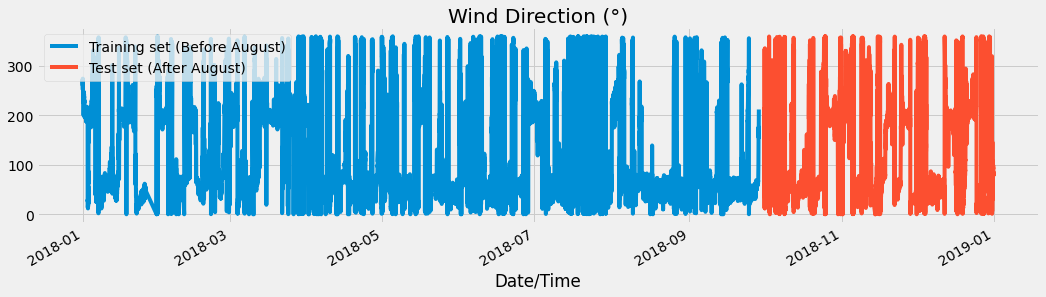

In [5]:
# Let's see what wind direction looks like
dataset["Wind Direction (°)"]['2018-01':'2018-09'].plot(figsize=(16,4),legend=True)
dataset["Wind Direction (°)"]['2018-10':'2018-12'].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before August)','Test set (After August)'])
plt.title('Wind Direction (°)')
plt.show()

In [6]:
# Scaling the training set(normalizing it)
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [7]:
# For each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(288,21862):
    X_train.append(training_set_scaled[i-288:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [8]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [9]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=25,batch_size=144)

Epoch 1/25
150/150 [==============================] - 210s 1s/step - loss: 0.0117
Epoch 2/25
150/150 [==============================] - 205s 1s/step - loss: 0.0060
Epoch 3/25
150/150 [==============================] - 213s 1s/step - loss: 0.0043
Epoch 4/25
150/150 [==============================] - 205s 1s/step - loss: 0.0035
Epoch 5/25
150/150 [==============================] - 204s 1s/step - loss: 0.0029
Epoch 6/25
150/150 [==============================] - 197s 1s/step - loss: 0.0025
Epoch 7/25
150/150 [==============================] - 197s 1s/step - loss: 0.0022
Epoch 8/25
150/150 [==============================] - 292s 2s/step - loss: 0.0021
Epoch 9/25
150/150 [==============================] - 276s 2s/step - loss: 0.0020
Epoch 10/25
150/150 [==============================] - 283s 2s/step - loss: 0.0019
Epoch 11/25
150/150 [==============================] - 248s 2s/step - loss: 0.0018
Epoch 12/25
150/150 [==============================] - 241s 2s/step - loss: 0.0018
Epoch 13/25
1

In [10]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 288 entires of test set have 288 previous values which is impossible to get unless we take the whole 
dataset_total = pd.concat((dataset["Wind Direction (°)"]['2018-01':'2018-09'],dataset["Wind Direction (°)"]['2018-10':'2018-12']),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set)- 288 :].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [11]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(288,11882):
    X_test.append(inputs[i-288:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted = regressor.predict(X_test)
predicted = sc.inverse_transform(predicted)

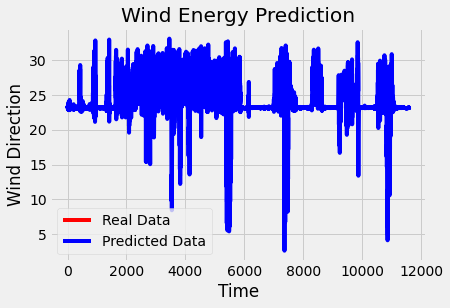

In [38]:
# Visualizing the results for LSTM
plot_predictions(test_set[288:11882],predicted_stock_price)

In [13]:
return_rmse(test_set[:11882-288],predicted)

The root mean squared error is 17.014897908843174.


In [33]:
temp=[]
for i in predicted_stock_price:
    a=float(i[0])
    temp.append(a)

In [36]:
data = pd.read_csv("predictions.csv") 
data["Wind Direction"] = temp
data.to_csv("predictions.csv", index=False)

AttributeError: 'list' object has no attribute 'shape'